## Question:
  1. Read and summarise the paper in about 50 words.
  2. Download the dataset in the paper, statistically analyse and
     describe it, so that it may be useful for posterity. (Include code
     snippets in your .ipynb file to evidence your analysis.)
  3. Train a classifier so that you are able to distinguish the commands
     in the dataset.
  4. Report the performance results using standard benchmarks.
  5. Record about 30 samples of each command in your voice and create a
     new dataset (including a new user id for yourself).  You may use a
     timer on your computer to synchronise.
  6. Fine tune your classifier to perform on your voice.
  7. Report the results.
  

In [2]:
import os
import tarfile
import urllib.request

DATASET_URL = "http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz"
data_dir = './data'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)


dataset_path = os.path.join(data_dir, 'speech_commands_v0.02.tar.gz')
urllib.request.urlretrieve(DATASET_URL, dataset_path)


with tarfile.open(dataset_path, 'r:gz') as tar:
    tar.extractall(path=data_dir)

print("Dataset downloaded and extracted.")


Dataset downloaded and extracted.


In [3]:
import tensorflow as tf
import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt
from IPython import display

AUTOTUNE = tf.data.AUTOTUNE


In [4]:
data_dir = pathlib.Path("./data")

commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)


Commands: ['speech_commands_v0.02.tar.gz' 'no' 'right' 'left' 'zero' 'seven'
 'forward' 'six' '_background_noise_' 'two' 'wow' 'happy' 'four' 'one'
 'down' 'sheila' 'learn' 'go' 'bed' 'validation_list.txt' 'yes' 'on'
 'house' 'bird' '.DS_Store' 'nine' 'stop' 'three' 'up' 'dog' 'backward'
 'testing_list.txt' 'tree' 'LICENSE' 'five' 'marvin' 'off' 'eight' 'cat'
 'follow' 'visual']


In [5]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2]

def get_waveform_and_label(file_path):
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    label = get_label(file_path)
    return waveform, label


files = tf.io.gfile.glob(str(data_dir) + '/*/*.wav')
files = tf.random.shuffle(files)

print("Number of audio files:", len(files))


files_ds = tf.data.Dataset.from_tensor_slices(files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)


Number of audio files: 105835


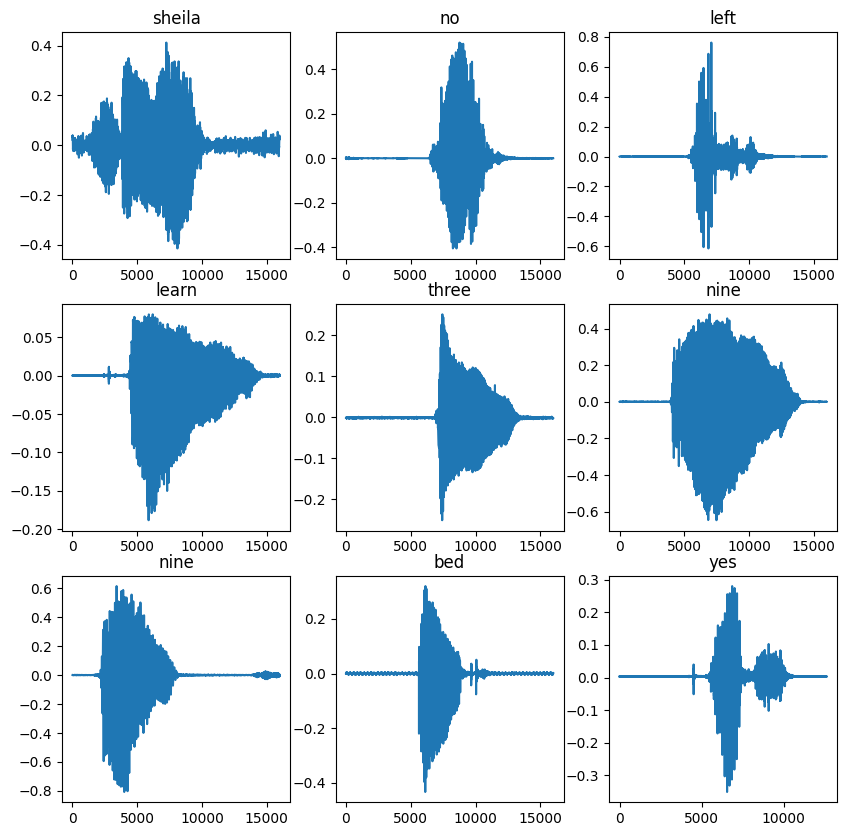

In [6]:
rows = 3
cols = 3
n = rows * cols
waveforms, labels = zip(*[(waveform.numpy(), label.numpy().decode('utf-8')) for waveform, label in waveform_ds.take(n)])

fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (waveform, label) in enumerate(zip(waveforms, labels)):
    r = i // cols
    c = i % cols
    axes[r][c].plot(waveform)
    axes[r][c].set_title(label)

plt.show()


In [7]:
def get_spectrogram(waveform):

    waveform = tf.signal.frame(waveform, frame_length=16000, frame_step=16000, pad_end=True)
    waveform = tf.reshape(waveform, [-1])

    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=-1)


    spectrogram = tf.image.resize(spectrogram, [161, 101])

    return spectrogram


def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

spectrogram_ds = waveform_ds.map(get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)


In [17]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)
    return output_ds

total_files = len(files)
train_size = int(0.8 * total_files)
val_size = int(0.1 * total_files)
test_size = total_files - train_size - val_size

train_files = files[:train_size]
val_files = files[train_size:train_size+val_size]
test_files = files[train_size+val_size:]

print(f"Total files: {total_files}")
print(f"Train files: {len(train_files)}")
print(f"Validation files: {len(val_files)}")
print(f"Test files: {len(test_files)}")

# Create datasets
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

# Batch the datasets
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

# Use buffered prefetching
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)
# train_files = files[:int(len(files) * 0.8)]
# val_files = files[int(len(files) * 0.8):]
# test_files = files[int(len(files) * 0.2):]

# train_ds = preprocess_dataset(train_files)
# val_ds = preprocess_dataset(val_files)
# test_ds= preprocess_dataset(test_files)

# batch_size = 64
# train_ds = train_ds.batch(batch_size)
# val_ds = val_ds.batch(batch_size)
# test_ds = test_ds.batch(batch_size)


Total files: 105835
Train files: 84668
Validation files: 10583
Test files: 10584


In [18]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)


model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(161, 101, 1), batch_size=32),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(commands))

])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

model.summary()


Input shape: (161, 101, 1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (32, 159, 99, 32)           │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 79, 49, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 77, 47, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 38, 23, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 36, 21, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 18, 10, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (32, 23040)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 128)                   │       2,949,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (32, 41)                    │           5,289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,047,209 (11.62 MB)

 Trainable params: 3,047,209 (11.62 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
EPOCHS = 5
history = model.fit(
    train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE),
    validation_data=val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE),
    epochs=EPOCHS
)

Epoch 1/5
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 221s 163ms/step - accuracy: 0.5324 - loss: 1.7515 - val_accuracy: 0.8373 - val_loss: 0.5794
Epoch 2/5
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.8583 - loss: 0.4905 - val_accuracy: 0.8557 - val_loss: 0.5211
Epoch 3/5
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.9100 - loss: 0.3014 - val_accuracy: 0.8482 - val_loss: 0.5747
Epoch 4/5
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.9317 - loss: 0.2166 - val_accuracy: 0.8619 - val_loss: 0.5589
Epoch 5/5
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.9515 - loss: 0.1543 - val_accuracy: 0.8642 - val_loss: 0.6191


In [20]:
model.save('speech_recognition_model.keras')


In [21]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.2f}")

166/166 ━━━━━━━━━━━━━━━━━━━━ 25s 152ms/step - accuracy: 0.8578 - loss: 0.6068
Test accuracy: 0.86


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
Predicted command: seven
Confidence: 1.00


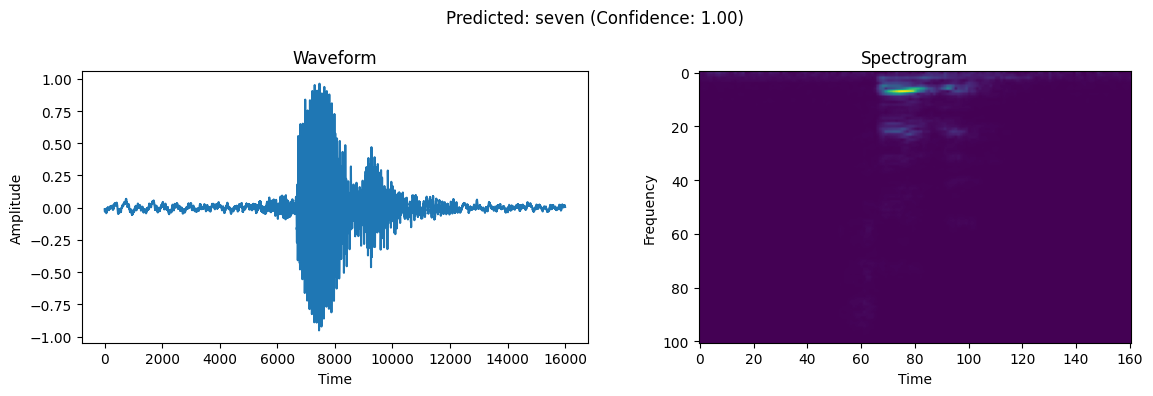

In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import librosa

def preprocess_audio_file(file_path, target_sample_rate=16000, target_duration=1.0):
    # Load the audio file
    audio, sample_rate = librosa.load(file_path, sr=None)

    # Resample if necessary
    if sample_rate != target_sample_rate:
        audio = librosa.resample(audio, orig_sr=sample_rate, target_sr=target_sample_rate)

    # Calculate target length
    target_length = int(target_sample_rate * target_duration)

    # Pad or truncate the audio to the target length
    if len(audio) < target_length:
        audio = np.pad(audio, (0, target_length - len(audio)))
    else:
        audio = audio[:target_length]

    return audio

def predict_audio(audio_file_path, model, commands):
    # Preprocess the audio file
    waveform = preprocess_audio_file(audio_file_path)
    spectrogram = get_spectrogram(waveform)
    spectrogram = tf.expand_dims(spectrogram, 0)  # Add batch dimension

    # Make prediction
    predictions = model.predict(spectrogram)
    predicted_index = tf.argmax(predictions[0]).numpy()
    predicted_command = commands[predicted_index]
    confidence = tf.nn.softmax(predictions[0])[predicted_index].numpy()

    return predicted_command, confidence, waveform

def plot_prediction(waveform, predicted_command, confidence):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(waveform)
    plt.title('Waveform')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    # Plot spectrogram
    spectrogram = get_spectrogram(waveform)
    plt.subplot(1, 2, 2)
    plt.imshow(tf.transpose(spectrogram)[0])
    plt.title('Spectrogram')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

    plt.suptitle(f'Predicted: {predicted_command} (Confidence: {confidence:.2f})')
    plt.tight_layout()
    plt.show()

# Example usage:
audio_file_path = '/content/seven08.wav'  # Replace with an actual file path
predicted_command, confidence, waveform = predict_audio(audio_file_path, model, commands)
print(f"Predicted command: {predicted_command}")
print(f"Confidence: {confidence:.2f}")

plot_prediction(waveform, predicted_command, confidence)

# The rest of the code (evaluate model on validation set and plot confusion matrix) remains the same